## Dependencies

In [ ]:
!pip install shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 31.8 MB/s 


In [ ]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

## Load data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DDR/train1.csv')
test = pd.read_csv('/content/drive/MyDrive/DDR/test1.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  20
Number of test samples:  20


id_code diagnosis
0  000c1434d8d7.png         2
1  0024cdab0c1e.png         1
2  002c21358ce6.png         3
3  005b95c28852.png         0
4  0083ee8054ee.png         4

# Model parameters

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

## Train test split

In [ ]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=seed)

# Data generator

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/content/drive/MyDrive/DDR/train_images",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

validation_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="/content/drive/MyDrive/DDR/train_images",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/content/drive/MyDrive/DDR/test_images",
        x_col="id_code",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 16 validated image filenames belonging to 5 classes.
Found 4 validated image filenames belonging to 2 classes.
Found 19 validated image filenames.


In [ ]:
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from torch.optim import lr_scheduler

In [ ]:
import cv2
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '/content', transform=None):
        super().__init__()
        print(df_data.values)
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index): 
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png') 
        #image = plt.imread(img_path)
        image = cv2.imread(img_path)
      
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


In [ ]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
train_path = "/content/drive/MyDrive/DDR/train_images"
test_path = "/content/drive/MyDrive/DDR/test_images"

In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/DDR/train1.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/DDR/test1.csv')

In [ ]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

[['000c1434d8d7' 2]
 ['0024cdab0c1e' 1]
 ['002c21358ce6' 3]
 ['005b95c28852' 0]
 ['0083ee8054ee' 4]
 ['0097f532ac9f' 0]
 ['00a8624548a9' 2]
 ['00b74780d31d' 2]
 ['00cb6555d108' 1]
 ['00cc2b75cddd' 0]
 ['00e4ddff966a' 2]
 ['00f6c1be5a33' 0]
 ['0104b032c141' 3]
 ['0124dffecf29' 1]
 ['0125fbd2e791' 0]
 ['012a242ac6ff' 2]
 ['014508ccb9cb' 0]
 ['0151781fe50b' 0]
 ['0161338f53cc' 2]
 ['0180bfa26c0b' 2]]
[['0005cfc8afb6']
 ['003f0afdcd15']
 ['006efc72b638']
 ['00836aaacf06']
 ['009245722fa4']
 ['009c019a7309']
 ['010d915e229a']
 ['0111b949947e']
 ['01499815e469']
 ['0167076e7089']
 ['01e4d86b3a30']
 ['020921b796d5']
 ['020f6983114d']
 ['021c207614d6']
 ['0229c0a80d42']
 ['024d0a225db1']
 ['0268f4382c67']
 ['0299d97f31f7']
 ['03042a663e54']
 ['030e06ddbb04']]


In [ ]:
print(train_data[1])

(tensor([[[-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         ...,
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837]],

        [[-2.0182, -2.0182, -2.0182,  ..., -2.0007, -2.0007, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0007, -2.0007, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0007, -2.0007, -2.0182],
         ...,
         [-2.0007, -2.0007, -2.0007,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0007, -2.0007, -2.0007,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0007, -2.0007,  ..., -2.0182, -2.0182, -2.0182]],

        [[-1.7522, -1.7522, -1.7522,  ..., -1.7696, -1.7522, -1.7522],
         [-1.7522, -1.7522, -1.7522,  ..., -

In [ ]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [ ]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 20
testing examples contain : 20
1
1
1


In [ ]:
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([16, 3, 224, 224])
Label shape : torch.Size([16])


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([2, 0, 3, 0, 0, 1, 3, 2, 4, 0, 2, 2, 0, 2, 0, 0])


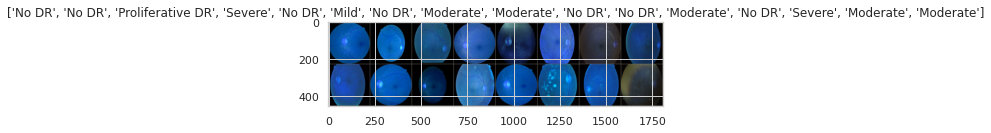

In [ ]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/{model_save_name}"

In [ ]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf 
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed") 
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    
    print('Training Completed Succesfully !')    
    return train_losses, test_losses, acc 

In [ ]:
train_losses, valid_losses, acc = train_and_test(5)

Model Training started.....
validation started for 1
Epoch: 1/5..  Training Loss: 1.627..  Valid Loss: 1.516..  Valid Accuracy: 0.250
Validation loss decreased (inf --> 1.515848).  Saving model ...
validation started for 2
Epoch: 2/5..  Training Loss: 1.609..  Valid Loss: 1.524..  Valid Accuracy: 0.000
validation started for 3
Epoch: 3/5..  Training Loss: 1.607..  Valid Loss: 1.533..  Valid Accuracy: 0.250
validation started for 4
Epoch: 4/5..  Training Loss: 1.591..  Valid Loss: 1.530..  Valid Accuracy: 0.250
validation started for 5
Epoch: 5/5..  Training Loss: 1.590..  Valid Loss: 1.544..  Valid Accuracy: 0.250
Training Completed Succesfully !


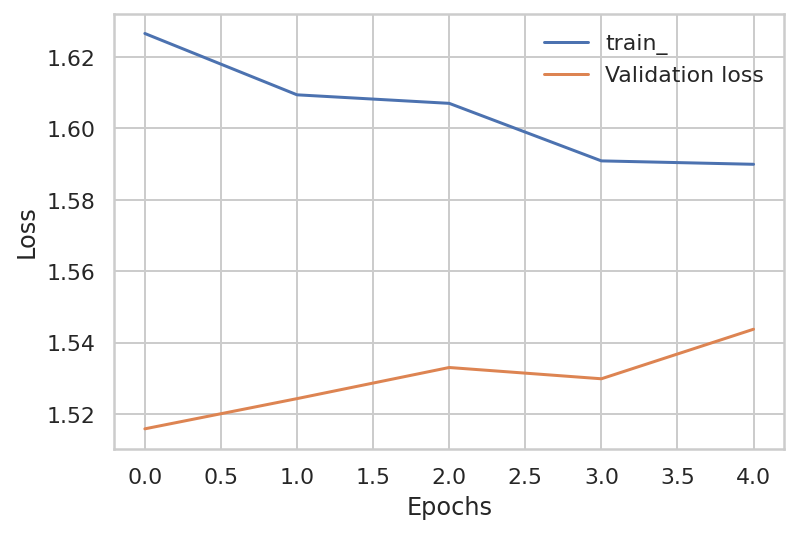

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='train_')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

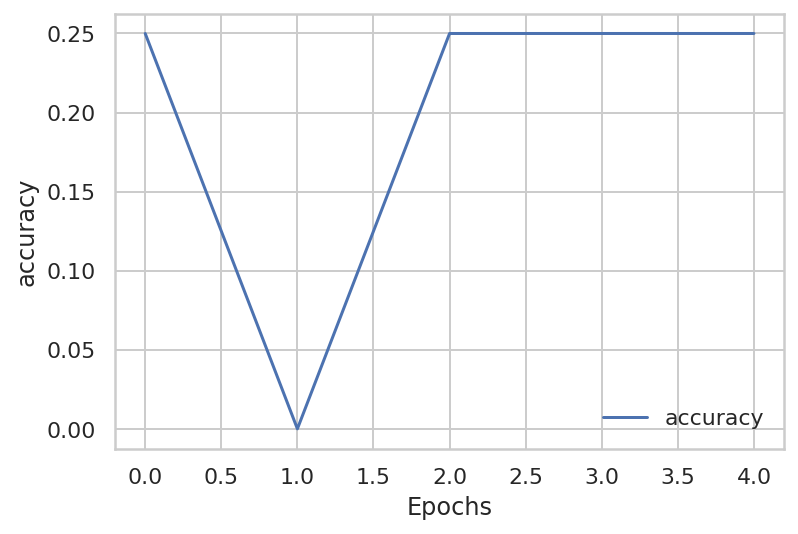

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)

**SHAP** **EXPLANATION**

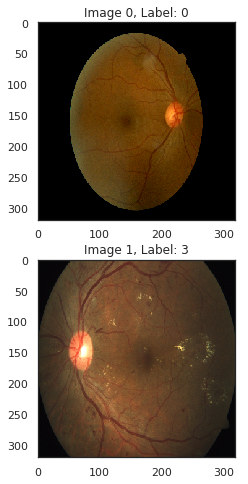

In [ ]:
n_explain = 2
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[8, 8])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

### Now the SHAP explanation

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

FOR 3 IMAGES

In [ ]:
n_explain = 3
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[12, 12])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

## Apply model to test set and output predictions

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

# Predictions class distribution

In [ ]:
fig = plt.subplots(1, 1, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [ ]:
results.to_csv('submission.csv', index=False)
results.head(10)

id_code  diagnosis
0  0005cfc8afb6          1
1  003f0afdcd15          3
2  006efc72b638          4
3  00836aaacf06          2
4  009245722fa4          4
5  009c019a7309          2
6  010d915e229a          3
7  0111b949947e          0
8  01499815e469          3
9  0167076e7089          0